In [1]:
import itertools
import os

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import requests

from fred import *

DATA_FOLDER = "data"

# What are we looking for?

Housing real estate is a market driven by several factors, including supply and demand. High supply and low demand drive market prices lower. Conversely, low supply and high demand drive market prices higher.

Home ownership is expensive: saving enough money for a down payment on a mortgage, paying mortgage debt, maintenance costs, property tax, etc. **Demand on the housing real estate market is driven by job abundance and quality**. The following attributes have a positive impact on home prices, or are positively correlated with home prices:

* positive job growth
* low unemployment rates
* high job diversity, where many industries make up the job market
* number of jobs in high growth industries (technology, healthcare, personal services, construction, etc)

# Data analysis

## Job growth

Data from the Quarterly Census of Employment and Wages retrieved on 2021/08/28 from https://milmi.org/DataSearch/QCEW.

In [2]:
to_drop = [
    "Year (copy)",
    "PeriodCode (copy)",
    "Area (copy)",
    "ID",
    "Area",
    "Area Type Name",
    "Industry Level",
    "StateSelected",
    "Period Type",
    "Period Type Description",
    "Reset Button",
    "State Code",
    "State Name",
    "# of Establishments"
]

ind_mi = pd.read_csv(
    os.path.join(DATA_FOLDER, "Industry_Full_Data_Michigan.csv"),
).drop(columns=to_drop)

ind_ingham = pd.read_csv(
    os.path.join(DATA_FOLDER, "Industry_Full_Data_Ingham.csv"),
).drop(columns=to_drop)

In [3]:
def add_date(row):
    year = row["Year"]
    month_in_quarter = int(row["variable"][5])
    month = (row["PeriodCode"] - 1)*3 + month_in_quarter
    return pd.to_datetime(f"{year}-{month}")

In [4]:
job_growth_mi = ind_mi[(ind_mi["PeriodCode"]!=0) & (ind_mi["Industry Code Title"]=="Total, All Industries")][["Year", "PeriodCode", "Month1Employment", "Month2Employment", "Month3Employment", "Ownership"]]
melted_mi = pd.melt(job_growth_mi, id_vars=["Year", "PeriodCode", "Ownership"], value_vars=["Month1Employment", "Month2Employment", "Month3Employment"])
sorted_mi = melted_mi.sort_values(by=["Year", "PeriodCode", "variable"])
sorted_mi["date"] = sorted_mi.apply(add_date, axis=1)

job_growth_ing = ind_ingham[(ind_ingham["PeriodCode"]!=0) & (ind_ingham["Industry Code Title"]=="Total, All Industries")][["Year", "PeriodCode", "Month1Employment", "Month2Employment", "Month3Employment", "Ownership"]]
melted_ing = pd.melt(job_growth_ing, id_vars=["Year", "PeriodCode", "Ownership"], value_vars=["Month1Employment", "Month2Employment", "Month3Employment"])
sorted_ing = melted_ing.sort_values(by=["Year", "PeriodCode", "variable"])
sorted_ing["date"] = sorted_ing.apply(add_date, axis=1)

From 2006 onward, data is divided by "Ownership" that includes "Private", "Federal Government", "State Government", and "Local Government". Before 2005 data is mostly for "Private". For data analysis simplicity, we'll focus on data from 2006 and later.

In [5]:
job_growth_agg_mi = sorted_mi[sorted_mi["Year"]>=2006].groupby("date")["value"].sum()
job_growth_agg_ing = sorted_ing[sorted_ing["Year"]>=2006].groupby("date")["value"].sum()

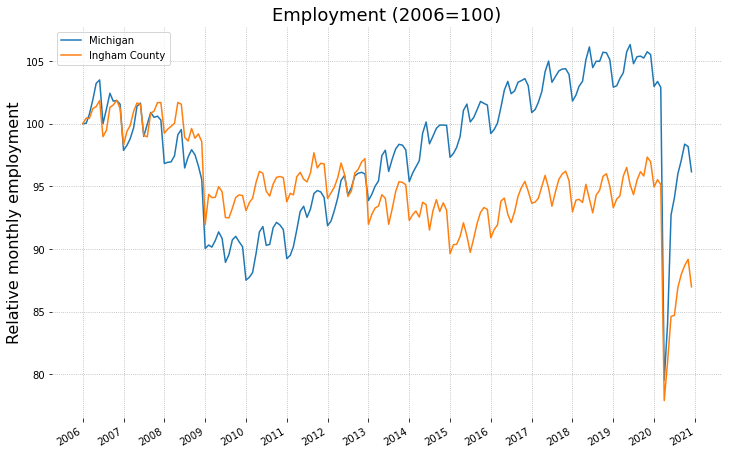

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(job_growth_agg_mi.index, job_growth_agg_mi/job_growth_agg_mi.iloc[0]*100, label="Michigan")
ax.plot(job_growth_agg_ing.index, job_growth_agg_ing/job_growth_agg_ing.iloc[0]*100, label="Ingham County")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,g}"))
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":")
ax.set_ylabel("Relative monthly employment", fontsize=16)
ax.set_title("Employment (2006=100)", fontsize=18)
fig.autofmt_xdate()
plt.legend();

The effect of the 2007 financial crisis can be seen as ~10% decrease in employment levels in Michigan, and ~7% decrease in employment levels in Ingham County. Michigan employment rebounded and grew consistently between 2009 and 2019. In contrast, Ingham County employment level stagnated between 2009 and 2013, then decreased until 2016 before growing until 2019.

In [7]:
job_growth_recent_mi = job_growth_agg_mi[job_growth_agg_mi.index>="2019-09-01"]
job_growth_recent_ing = job_growth_agg_ing[job_growth_agg_ing.index>="2019-09-01"]

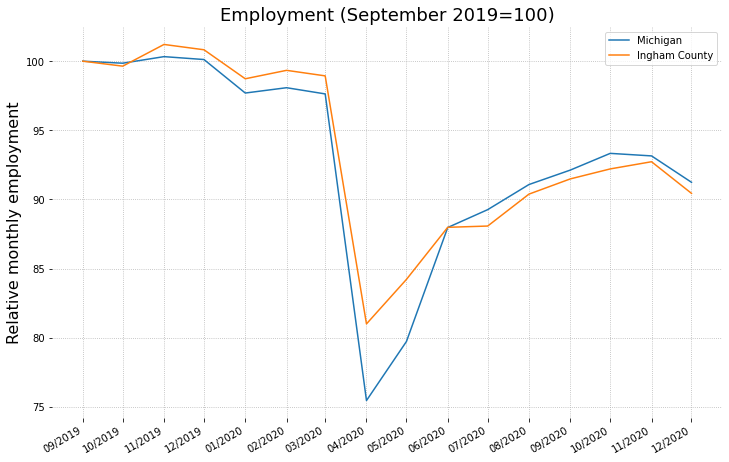

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(job_growth_recent_mi.index, job_growth_recent_mi/job_growth_recent_mi.iloc[0]*100, label="Michigan")
ax.plot(job_growth_recent_ing.index, job_growth_recent_ing/job_growth_recent_ing.iloc[0]*100, label="Ingham County")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%Y"))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,g}"))
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":")
ax.set_ylabel("Relative monthly employment", fontsize=16)
ax.set_title("Employment (September 2019=100)", fontsize=18)
fig.autofmt_xdate()
plt.legend();

The COVID19 pandemic led to a large decrease in employment in both geographies: -25% across Michigan and -18% in Ingham County. In 2020 Michigan and Ingham County recovered about half of their job losses, compared to 2019 levels.

## Unemployment

Unemployment data was downloaded from https://www.bls.gov/lau/ on 2021/08/28.

In [9]:
# download data
base_url = "https://www.bls.gov/lau/laucnty{}.xlsx"

for year in range(1990, 2021):
    response = requests.get(base_url.format(str(year)[-2:]))
    with open(os.path.join(DATA_FOLDER, "unemployment", "laucnty{}.xlsx".format(str(year)[-2:])), "wb") as f:
        f.write(response.content)

In [10]:
# consolidate individual yearly files into a single dataframe
lau_data_types = {
    "laus_code": str,
    "state_fips": str,
    "county_fips": str,
    "county_state_name": str,
    "year": int,
    "empty": str,
    "labor_force": "Int32",
    "employed": "Int32",
    "unemployed_level": "Int32",
    "unemployed_rate": float,
}

unemp = pd.DataFrame(columns=["year", "country_unemployed_rate", "michigan_unemployed_rate", "ingham_unemployed_rate"])

for year in range(1990, 2021):
    df = pd.read_excel(
        os.path.join(DATA_FOLDER, "unemployment", "laucnty{}.xlsx".format(str(year)[-2:])),
        skiprows=5,
        skipfooter=3,
        names=lau_data_types.keys(),
        dtype=lau_data_types,
        na_values="N.A.",
        thousands=","
    ).drop(columns="empty")
    df_mi = df[df["state_fips"]=="26"]
    df_ingham = df[df["county_state_name"]=="Ingham County, MI"]
    unemp = unemp.append({
        "year": year,
        "country_unemployed_rate": df["unemployed_level"].sum() / df["labor_force"].sum() * 100,
        "michigan_unemployed_rate": df_mi["unemployed_level"].sum() / df_mi["labor_force"].sum() * 100,
        "ingham_unemployed_rate": df_ingham["unemployed_level"].sum() / df_ingham["labor_force"].sum() * 100,
    }, ignore_index=True)

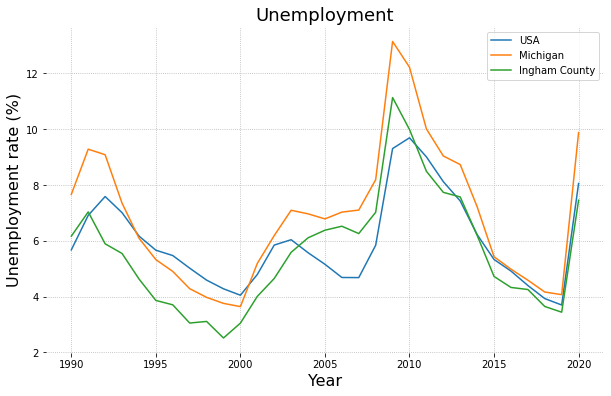

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(unemp["year"], unemp["country_unemployed_rate"], label="USA")
ax.plot(unemp["year"], unemp["michigan_unemployed_rate"], label="Michigan")
ax.plot(unemp["year"], unemp["ingham_unemployed_rate"], label="Ingham County")
ax.set_title("Unemployment", fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Unemployment rate (%)", fontsize=16)
plt.legend()
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":");

The effect of financial crises of 1990, 2000, and 2007 are readily visible on unemployment rates across all geographies. We note that Ingham County unemployment levels have always been lower than Michigan since 1990, especially during crises when the difference between these two geographies is the largest. Unemployment levels in Ingham County rise less than in Michigan during financial crises, indicating that jobs in this county are more resilient than at the state level.

## Economic growth

Data was downloaded on 2021/08/28 from the FRED API at https://api.stlouisfed.org/fred/series/observations. The data series IDs are:

* US: GDP
* Michigan: MINGSP
* Ingham County: GDPALL26065

In [12]:
# download data
dtypes = {"date": "date", "value": "float"}
gdp_ing = parse_fred(download_fred("GDPALL26065"), dtypes=dtypes)
gdp_mi = parse_fred(download_fred("MINGSP"), dtypes=dtypes)
gdp_us = parse_fred(download_fred("GDP"), dtypes=dtypes)

In [13]:
# normalize data (2001/01/01 = 100)
gdp_norm_ing = gdp_ing["value"] / gdp_ing[gdp_ing["date"]=="2001-01-01"]["value"].values * 100
gdp_norm_mi = gdp_mi["value"] / gdp_mi[gdp_mi["date"]=="2001-01-01"]["value"].values * 100
gdp_norm_us = gdp_us["value"] / gdp_us[gdp_us["date"]=="2001-01-01"]["value"].values * 100

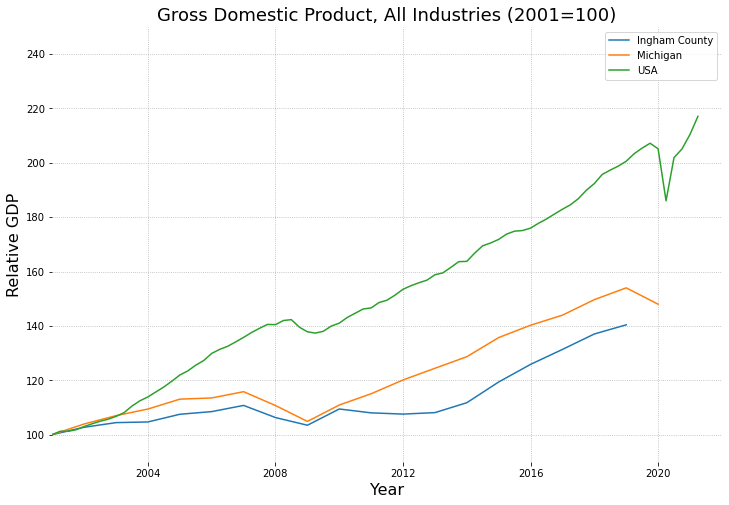

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(gdp_ing["date"], gdp_norm_ing, label="Ingham County")
ax.plot(gdp_mi["date"], gdp_norm_mi, label="Michigan")
ax.plot(gdp_us["date"], gdp_norm_us, label="USA")
ax.set_title("Gross Domestic Product, All Industries (2001=100)", fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Relative GDP", fontsize=16)
ax.set_xlim("2001-01-01", "2022-01-01")
ax.set_ylim(90, 250)
plt.legend()
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":");

After the 2007 financial crisis, economic growth in Ingham County has stagnated until 2013 before increasing and catchup up with state-wide and nation-wide growth rates. This is consistent with stagnating employment levels in Ingham County seen in the early part of the 2010's decade. Because FRED does not provide data past 2019 for Ingham County, we cannot conclude on more recent growth dynamics.

## Median household income

Data was downloaded on 2021/08/28 from the FRED API at https://api.stlouisfed.org/fred/series/observations. The data series IDs are:

* US: MHIUS00000A052NCEN
* Michigan: MHIMI26000A052NCEN
* Ingham County: MHIMI26065A052NCEN

In [15]:
dtypes = {"date": "date", "value": "float"}
hh_med_ing = parse_fred(download_fred("MHIMI26065A052NCEN"), dtypes=dtypes)
hh_med_us = parse_fred(download_fred("MHIUS00000A052NCEN"), dtypes=dtypes)
hh_med_mi = parse_fred(download_fred("MHIMI26000A052NCEN"), dtypes=dtypes)

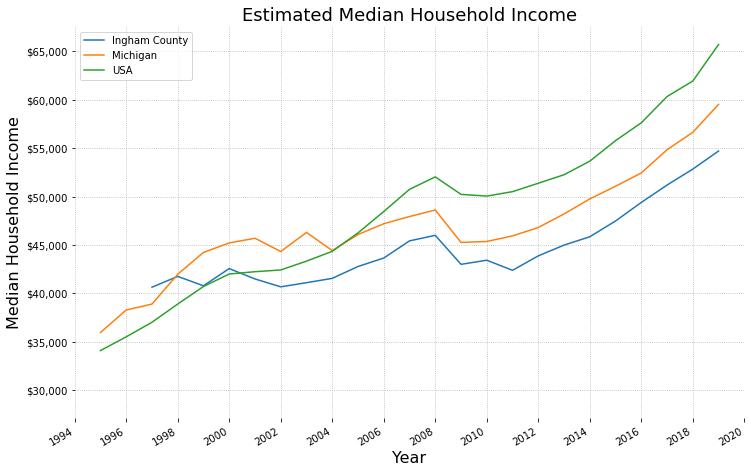

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(hh_med_ing["date"], hh_med_ing["value"], label="Ingham County")
ax.plot(hh_med_mi["date"], hh_med_mi["value"], label="Michigan")
ax.plot(hh_med_us["date"], hh_med_us["value"], label="USA")
ax.set_title("Estimated Median Household Income", fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Median Household Income", fontsize=16)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("${x:,g}"))
fig.autofmt_xdate()
ax.set_xlim("1994-01-01", "2020-01-01")
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":")
plt.legend();

Since 2000, the estimated median household income in Ingham County paralleled that of Michigan while are always lower. During the last decade, Ingham County household have consistently increased their income, which rose from \$43,414 in 2010 to \$54,704 in 2019. This is an increase of 26% in 9 years, or \$1,254 per year.

## Job growth by industry

To understand how dynamic the job market is, we analyze wages and employment changes across industries since 2016.

Data comes from the Quarterly Census of Employment and Wages. I was retrieved on 2021/08/28 from https://milmi.org/DataSearch/QCEW.

In [17]:
mask_mi = (ind_mi["Industry Code"] <= 100) & (ind_mi["Period"]=="Annual") & (ind_mi["Ownership"]=="Private")
mask_ing = (ind_ingham["Industry Code"] <= 100) & (ind_ingham["Period"]=="Annual") & (ind_ingham["Ownership"]=="Private")

ind_annual_mi = ind_mi[mask_mi].sort_values("Year")
ind_annual_mi.loc[:, "Year"] = pd.to_datetime(ind_annual_mi["Year"], format="%Y")

ind_annual_ing = ind_ingham[mask_ing].sort_values("Year")
ind_annual_ing.loc[:, "Year"] = pd.to_datetime(ind_annual_ing["Year"], format="%Y")

In [18]:
employ_annual_mi = ind_annual_mi.groupby(["Year", "Industry Code Title"])["Average Employment"].sum().reset_index()
employ_annual_ing = ind_annual_ing.groupby(["Year", "Industry Code Title"])["Average Employment"].sum().reset_index()

In [19]:
wages_annual_mi = ind_annual_mi.groupby(["Year", "Industry Code Title"])["Average Weekly Wages"].sum().reset_index()
wages_annual_ing = ind_annual_ing.groupby(["Year", "Industry Code Title"])["Average Weekly Wages"].sum().reset_index()

In [20]:
top_wages_mi = wages_annual_mi[(wages_annual_mi["Year"]>="2016") & (wages_annual_mi["Industry Code Title"] != "Total, All Industries")].groupby("Industry Code Title")["Average Weekly Wages"].median().sort_values(ascending=False)
top_wages_ing = wages_annual_ing[(wages_annual_ing["Year"]>="2016") & (wages_annual_ing["Industry Code Title"] != "Total, All Industries")].groupby("Industry Code Title")["Average Weekly Wages"].median().sort_values(ascending=False)

In [21]:
# calculat average wages for Michigan
wages_total = 0
employ_total = 0

for name in top_wages_mi.index:
    for year in ("2016", "2017", "2018", "2019", "2020"):
        mask = (ind_annual_mi["Year"] == year) & (ind_annual_mi["Industry Code Title"] == name)
        employ = ind_annual_mi[mask]["Average Employment"].iloc[0]
        wages = ind_annual_mi[mask]["Average Weekly Wages"].iloc[0]
        wages_total += employ * wages
        employ_total += ind_annual_mi[mask]["Average Employment"].iloc[0]
        
wages_weekly_avg_mi = wages_total / employ_total

In [22]:
# calculate average wages for Ingham County
wages_total = 0
employ_total = 0

for name in top_wages_ing.index:
    for year in ("2016", "2017", "2018", "2019", "2020"):
        mask = (ind_annual_ing["Year"] == year) & (ind_annual_ing["Industry Code Title"] == name)
        try:
            employ = ind_annual_ing[mask]["Average Employment"].iloc[0]
            wages = ind_annual_ing[mask]["Average Weekly Wages"].iloc[0]
            wages_total += employ * wages
            employ_total += ind_annual_ing[mask]["Average Employment"].iloc[0]
        # missing data leads to an IndexError
        except IndexError:
            pass
        
wages_weekly_avg_ing = wages_total / employ_total

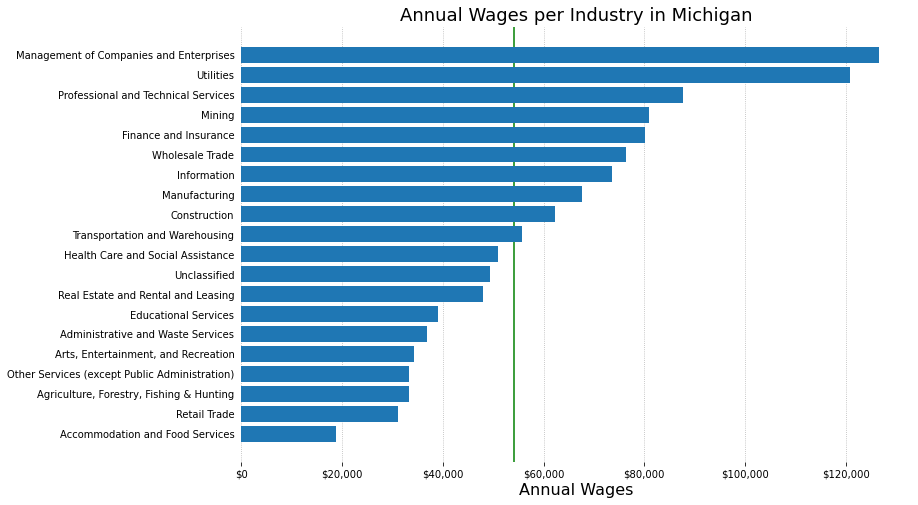

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(top_wages_mi.index[::-1], top_wages_mi[::-1]*52, zorder=4)
ax.axvline(wages_weekly_avg_mi * 52, c="g")
ax.set_title("Annual Wages per Industry in Michigan", fontsize=18)
ax.set_xlabel("Annual Wages", fontsize=16)
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("${x:,g}"))
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
plt.grid(axis="x", ls=":")
ax.tick_params(axis="y", left=False);

In Mighigan, we focus on the 10 industries with the highest paying jobs. In the period between 2016 and 2020, the average wages of jobs in these industries are above the average wages across all industries, which is \$54,106. The top 10 industries are, in order of decrasing average wages:

* management of companies and enterprises
* utilities
* professional and technical services
* mining
* finance and insurance
* wholesale trade
* information
* manufacturing
* construction
* transportation and warehousing

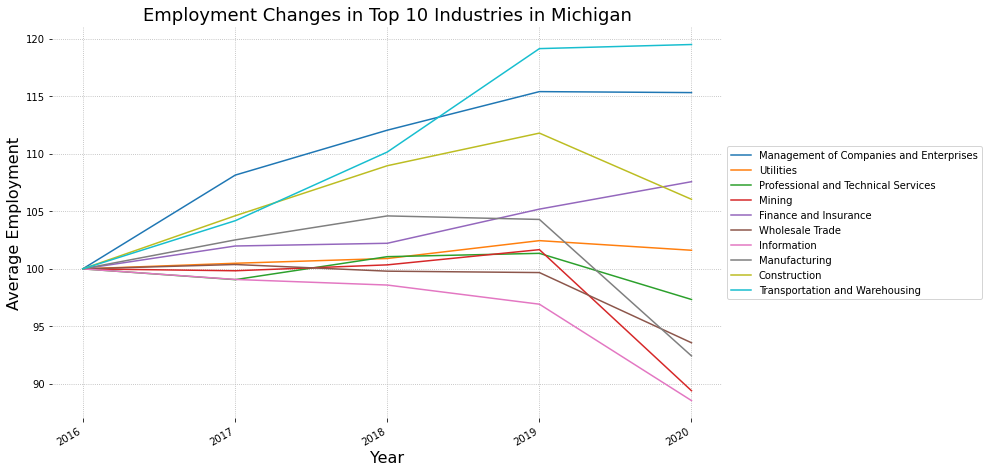

In [24]:
colors = tuple(f"C{i}" for i in range(10))
styles = tuple(itertools.product(("solid", "dashed"), colors))

fig, ax = plt.subplots(figsize=(12, 8))
i = 0
for name in top_wages_mi.index[:10]:
    mask = (employ_annual_mi["Industry Code Title"] == name) & (employ_annual_mi["Year"] >= "2016")
    init_employ = employ_annual_mi[mask & (employ_annual_mi["Year"] == "2016")]["Average Employment"].iloc[0]
    ax.plot(
        employ_annual_mi[mask]["Year"],
        employ_annual_mi[mask]["Average Employment"] / init_employ * 100,
        color=styles[i][1],
        linestyle=styles[i][0],
        label=name,
    )
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,g}"))
    i += 1
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":")
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Average Employment", fontsize=16)
ax.set_title("Employment Changes in Top 10 Industries in Michigan", fontsize=18)
fig.autofmt_xdate()
ax.legend(bbox_to_anchor=(1, 0.5), loc='center left');

Five out of 10 of these top paying industries are showing employment growth. These industries are, in order of decrasing rate of growth:

1. transportation and warehousing
2. management of companies and enterprises
3. finance and insurance
4. construction
5. utilities

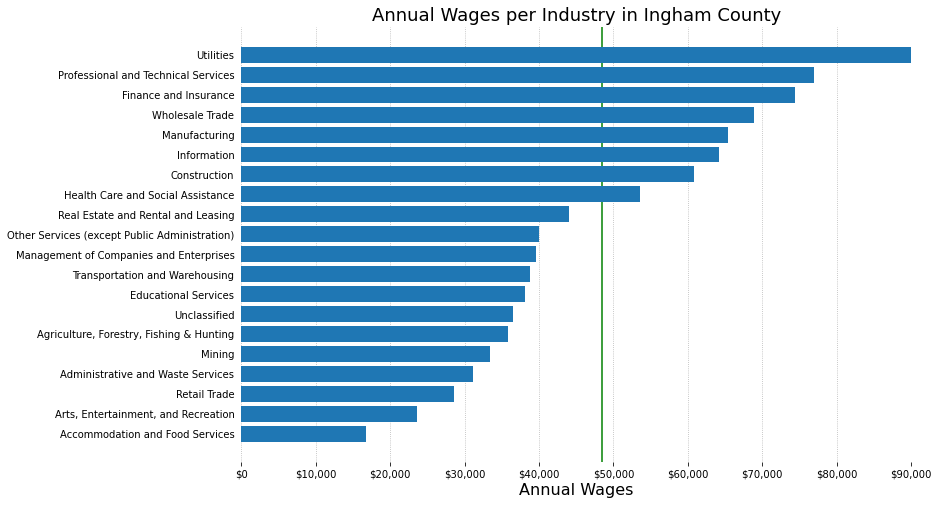

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(top_wages_ing.index[::-1], top_wages_ing[::-1]*52, zorder=4)
ax.axvline(wages_weekly_avg_ing * 52, c="g")
ax.set_title("Annual Wages per Industry in Ingham County", fontsize=18)
ax.set_xlabel("Annual Wages", fontsize=16)
ax.set_xlim(0, 90000)
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("${x:,g}"))
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
plt.grid(axis="x", ls=":")
ax.tick_params(axis="y", left=False);

In Ingham County, we focus on the 8 industries with average wages above the average wages across all industries, which is \$48,406.

* utilities
* professional and technical services
* finance and insurance
* wholesale trade
* manufacturing
* information
* construction
* health care and social assistance

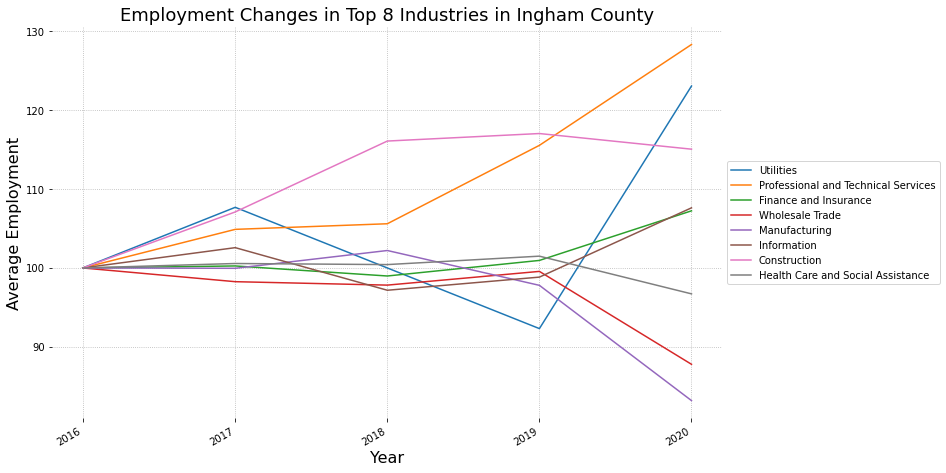

In [26]:
colors = tuple(f"C{i}" for i in range(10))
styles = tuple(itertools.product(("solid", "dashed"), colors))

fig, ax = plt.subplots(figsize=(12, 8))
i = 0
for name in top_wages_ing.index[:8]:
    mask = (employ_annual_ing["Industry Code Title"] == name) & (employ_annual_ing["Year"] >= "2016")
    init_employ = employ_annual_ing[mask & (employ_annual_ing["Year"] == "2016")]["Average Employment"].iloc[0]
    ax.plot(
        employ_annual_ing[mask]["Year"],
        employ_annual_ing[mask]["Average Employment"] / init_employ * 100,
        color=styles[i][1],
        linestyle=styles[i][0],
        label=name,
    )
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,g}"))
    i += 1
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":")
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Average Employment", fontsize=16)
ax.set_title("Employment Changes in Top 8 Industries in Ingham County", fontsize=18)
fig.autofmt_xdate()
ax.legend(bbox_to_anchor=(1, 0.5), loc='center left');

Five out of 8 of these top paying industries are showing employment growth. These industries are, in order of decrasing rate of growth:

1. professional and technical services
2. utilities
3. construction
4. information
5. finance and insurance

## Job diversity

When many industries make up the job market, the economy is more resilient and fewer people are likely to lose their job if economic conditions become less favorable. When jobs are more stable, the demand for buying homes is likely to remain strong.

We focus on data between 2017 and 2019 because the data for these years has the same industries. Data for years after 2019 and before 2017 have a different set of industries, making comparisons between years more complicated.

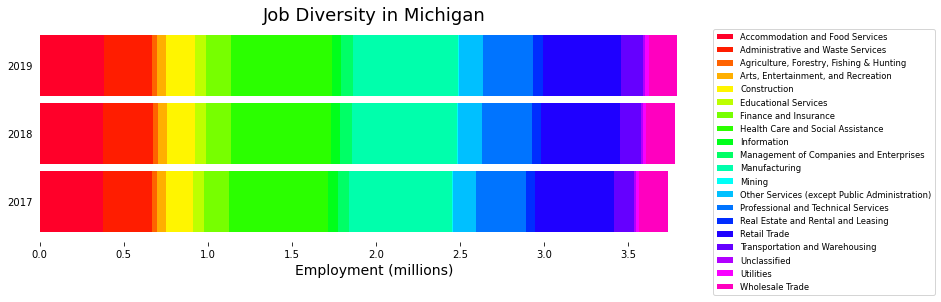

In [27]:
ind_titles = sorted(ind_annual_mi[(ind_annual_mi["Year"]=="2019") & (ind_annual_mi["Industry Code Title"]!="Total, All Industries")]["Industry Code Title"].tolist())
category_colors = plt.get_cmap('gist_rainbow')(np.linspace(0, 1, len(ind_titles)))

fig, ax = plt.subplots(figsize=(12, 4))

for year in ("2017", "2018", "2019"):
    ind_year = ind_annual_mi[(ind_annual_mi["Year"]==year) & (ind_annual_mi["Industry Code Title"]!="Total, All Industries")]
    employ = ind_year[["Average Employment", "Industry Code Title"]].set_index("Industry Code Title").sort_values(by="Industry Code Title")
    employ_sum = employ.cumsum()
    for i, (colname, color) in enumerate(zip(ind_titles, category_colors)):
        width = employ.reset_index(drop=True).iloc[i]/1e6
        start = employ_sum.reset_index(drop=True).iloc[i]/1e6 - width
        rects = ax.barh(
            year,
            width,
            left=start,
            height=0.9,
            label=colname,
            color=color,
        )
    
for side in ("left", "right", "top", "bottom"):
    ax.spines[side].set_visible(False)
    
ax.tick_params(axis="y", left=False)
ax.set_xlabel("Employment (millions)", fontsize=14)
ax.set_title("Job Diversity in Michigan", fontsize=18, pad=3)
    
ax.legend(
    labels=ind_titles,
    ncol=1,
    bbox_to_anchor=(1, 1),
    fontsize='small',
);

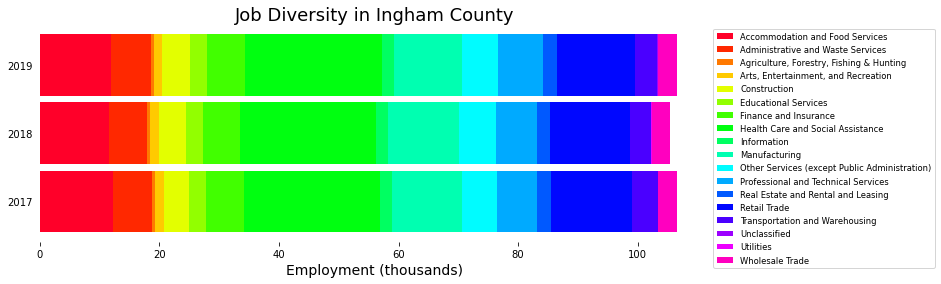

In [28]:
ind_titles = sorted(ind_annual_ing[(ind_annual_ing["Year"]=="2019") & (ind_annual_ing["Industry Code Title"]!="Total, All Industries")]["Industry Code Title"].tolist())
category_colors = plt.get_cmap('gist_rainbow')(np.linspace(0, 1, len(ind_titles)))

fig, ax = plt.subplots(figsize=(12, 4))

for year in ("2017", "2018", "2019"):
    ind_year = ind_annual_ing[(ind_annual_ing["Year"]==year) & (ind_annual_ing["Industry Code Title"]!="Total, All Industries")]
    employ = ind_year[["Average Employment", "Industry Code Title"]].set_index("Industry Code Title").sort_values(by="Industry Code Title")
    employ_sum = employ.cumsum()
    for i, (colname, color) in enumerate(zip(ind_titles, category_colors)):
        width = employ.reset_index(drop=True).iloc[i]/1e3
        start = employ_sum.reset_index(drop=True).iloc[i]/1e3 - width
        rects = ax.barh(
            year,
            width,
            left=start,
            height=0.9,
            label=colname,
            color=color,
        )
    
for side in ("left", "right", "top", "bottom"):
    ax.spines[side].set_visible(False)
    
ax.tick_params(axis="y", left=False)
ax.set_xlabel("Employment (thousands)", fontsize=14)
ax.set_title("Job Diversity in Ingham County", fontsize=18, pad=3)
    
ax.legend(
    labels=ind_titles,
    ncol=1,
    bbox_to_anchor=(1, 1),
    fontsize='small',
);

The job diversity in Ingham County appears similar to diversity seen at the Michigan level, indicating that Ingham County jobs are fairly diverse. Notable differences between Ingham County and Michigan include:

* a larger proportion of jobs in health care and social assistance in Ingham County
* some industries are represented in Michigan but not in Ingham County, such as management of companies and enterprises, and mining (which has very few jobs)

## Summary

| Data                                            | Value | Evolution | Impact on/correlation with prices |
|-------------------------------------------------|-------|-----------|-----------------------------------|
| Job Growth                                      |    Low| Increasing|                                  -|
| Unemployment                                    |    Low| Decreasing|                                  +|
| Economic Growth                                 | Medium| Increasing|                                  +|
| Median Household Income                         | Medium| Increasing|                                  +|
| Employment in Growing Industries                |   High| Increasing|                                  +|
| Job Diversity                                   |   High|          ?|                                  +|